# Amex - Model Part

In [1]:
import numpy as np
import pandas as pd
import os

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import sklearn

In [2]:
train = pd.read_pickle('../input/amexshycombinedfeatures/train.pkl')
trainY = pd.read_pickle('../input/amexshycombinedfeatures/trainY.pkl')

In [3]:
train.columns = [f'f_{_}' for _ in range(0,train.shape[1])]
for i in train.columns:
    if train[i].dtypes == 'object':
        train[i]=train[i].apply(lambda x: hash(str(x))%997)
import pickle
with open('../input/amexshycombinedfeatures/selected1.pickle', 'rb') as file:    
    selected1 = pickle.load(file)    
with open('../input/amexshycombinedfeatures/selected2.pickle', 'rb') as file:    
    selected2 = pickle.load(file)    
with open('../input/amexshycombinedfeatures/selected3.pickle', 'rb') as file:    
    selected3 = pickle.load(file)    
columns = []
for i,j,k,l in zip(train.columns,selected1,selected2,selected3):
    if j == k == l == True:
        columns.append(i)
train = train[columns]
gc.collect()

0

In [4]:
# model robustness indicator
def calc_vdr(pred, actual, vdr_cutoff = 0.2):
    # Function to calculate VDR at a given cutoff

    df_vdr_train = pd.DataFrame(zip(pred), columns = ['predicted_proba'])
    df_vdr_train['actual'] = np.array(actual)
    df_vdr_train = df_vdr_train.sort_values(by = 'predicted_proba', ascending = False)
    num_bad = df_vdr_train['actual'].sum()
    top_20_pct = int(len(df_vdr_train['actual'])*vdr_cutoff)
    vdr = df_vdr_train.head(top_20_pct)['actual'].sum()/num_bad
    return vdr

# evaluation matrix

# 4% cutoff measures the true positive rate of the 4% data
# positives are given 20x weights
# cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
# the code above indicates that if we successfully detect more positive cases, we will get less cut_samples
# since negative samples have weight of 1, we should have more samples to let cut_vals reach threshold
# the top four value equals to the ture positive numbers in cut_vals samples/the number of all true positive samples
# therefore, our models should be more sensitive to true positive cases and have a larger true positive rate

# gini = 2(ROC-0.5)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    print(f'Top four({len(cut_vals[:,0])} total cases) has {top_four*100}% positives cases being predicted')    

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    print(f'Gini value is {gini[1]/gini[0]}')
    
    
    return 0.5 * (gini[1]/gini[0] + top_four)

# matplotlib
def plot_auc(y_test, pred_prob1,pred_prob2,modelname,modelname2):
    from sklearn.metrics import roc_curve

    # roc curve for models
    fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1, pos_label=1)
    fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2, pos_label=1)


    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=modelname)
    plt.plot(fpr2, tpr2, linestyle='--',color='green', label=modelname2)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
#     plt.savefig('ROC',dpi=)
    plt.show()
    
def evaluation(gbm, train_x, valid_x, sig):
    # lightgbm single model evaluation in cv
    # predict the valid dataset in cv
    if sig == 'class':
        train_score_lgm = gbm.predict_proba(train_x)[:,1]
        valid_score_lgm = gbm.predict_proba(valid_x)[:,1]
    elif sig == 'reg':
        train_score_lgm = gbm.predict(train_x)
        valid_score_lgm = gbm.predict(valid_x)
    # get roc score
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm)
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm)
    # get the provided evaluation metrics of Gini and D score
    score_train = amex_metric_mod(train_y, train_score_lgm)
    score_valid = amex_metric_mod(valid_y, valid_score_lgm)

    print('LGB - METRICS')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(roc_auc_train , roc_auc_valid))
    print(f'LGB: train_vdr score: {calc_vdr(train_score_lgm,actual=train_y)}')
    print(f'LGB: valid_vdr score: {calc_vdr(valid_score_lgm,actual=valid_y)}')
    #joblib.dump(gbm,'./model_shy/lgm'+str(round(sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm),5)).replace('0.','')+'.model')
    print('LGB: Train_score: {:.4f} valid_score: {:.4f}'.format(score_train, score_valid))

In [5]:
import pickle
with open('../input/modelspackages/models_lgb_120_004_800_200_04_03.pickle','rb') as file:
    models1 = pickle.load(file)
with open('../input/modelspackages/models_lgb_120_004_800_200_04_04.pickle','rb') as file:
    models2 = pickle.load(file)
with open('../input/modelspackages/models_lgb_140_003_800_200_06_03.pickle','rb') as file:
    models3 = pickle.load(file)
with open('../input/modelspackages/models_xgbc_200_01_06_5_03.pickle','rb') as file:
    models4 = pickle.load(file)
with open('../input/modelspackages/models_xgbr_300_005_03_5_02.pickle','rb') as file:
    models5 = pickle.load(file)

In [6]:
modelNum = [2022,725,233,514,2333,0]
models = []
newTrainDF = pd.DataFrame()

for idx,_ in enumerate(modelNum):
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)
    list_ = []
    list_2 = []
    list_3 = []
    list_4 = []
    list_5 = []
    y_ = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, trainY)):
        train_x, train_y = train.iloc[train_idx], trainY.iloc[train_idx]
        valid_x, valid_y = train.iloc[valid_idx], trainY.iloc[valid_idx]
        
        gbm2 = models1[idx*5 + n_fold][0]
        gbm3 = models2[idx*5 + n_fold][0]
        gbm = models3[idx*5 + n_fold][0]
        
        list_+= list(gbm.predict_proba(valid_x)[:,1])
        list_2+= list(gbm2.predict_proba(valid_x)[:,1])
        list_3+= list(gbm3.predict_proba(valid_x)[:,1])
        
        train_x = train_x.replace([np.inf,-np.inf],0)
        train_x.fillna(0,inplace=True)
        valid_x = valid_x.replace([np.inf,-np.inf],0)
        valid_x.fillna(0,inplace=True)
        
        xgb1 = models4[idx*5 + n_fold][0]
        xgb2 = models5[idx*5 + n_fold][0]
        list_4+= list(xgb1.predict_proba(valid_x)[:,1])
        list_5+= list(xgb2.predict(valid_x))
        y_ += list(valid_y)
        print(idx,n_fold)
        
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()  
    newTrainDF[f'{_}_pred'] = list_
    newTrainDF[f'{_}_pred2'] = list_2
    newTrainDF[f'{_}_pred3'] = list_3
    newTrainDF[f'{_}_pred4'] = list_4
    newTrainDF[f'{_}_pred5'] = list_5
    gc.collect()
           

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4


In [7]:
newTrainDF                                                    

,2022_pred,2022_pred2,2022_pred3,2022_pred4,2022_pred5,725_pred,725_pred2,725_pred3,725_pred4,725_pred5,...,2333_pred,2333_pred2,2333_pred3,2333_pred4,2333_pred5,0_pred,0_pred2,0_pred3,0_pred4,0_pred5
0,0.001478,0.001888,0.002108,0.002893,0.000823,0.006012,0.007132,0.010058,0.006341,0.011910,...,0.001535,0.001415,0.002221,0.003336,0.001747,0.730659,0.706918,0.843714,0.640688,0.623625
1,0.001226,0.001693,0.001951,0.002337,-0.005181,0.990484,0.991330,0.991808,0.980401,0.819736,...,0.138657,0.132265,0.135988,0.216971,0.202100,0.001055,0.001036,0.000872,0.001119,-0.009762
2,0.981784,0.984609,0.987211,0.984045,0.915812,0.010554,0.011195,0.013696,0.012151,0.002006,...,0.002390,0.001783,0.003170,0.004121,-0.015429,0.001778,0.002155,0.001924,0.001898,-0.012886
3,0.150972,0.156217,0.137153,0.199551,0.133011,0.002842,0.002702,0.003065,0.003761,-0.004227,...,0.001631,0.001939,0.001493,0.003439,-0.002182,0.002351,0.001901,0.002253,0.001918,0.028651
4,0.002397,0.001636,0.003085,0.002225,0.002802,0.981556,0.988035,0.986810,0.987502,1.049586,...,0.883916,0.870825,0.860023,0.800924,0.699448,0.992135,0.990637,0.988179,0.990448,0.970190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,0.990038,0.992553,0.988378,0.988840,1.000397,0.747538,0.766288,0.726014,0.649845,0.639165,...,0.160887,0.178610,0.147497,0.115929,0.210982,0.991072,0.991712,0.988248,0.985834,1.018750
458909,0.001042,0.001200,0.002086,0.003385,0.006687,0.008975,0.015493,0.013397,0.017093,0.007241,...,0.358785,0.449039,0.455791,0.399906,0.408139,0.000709,0.001066,0.001358,0.001566,0.001918
458910,0.321152,0.335943,0.280111,0.235822,0.255736,0.000599,0.000500,0.000661,0.000738,-0.006240,...,0.010354,0.015805,0.010256,0.018945,-0.008118,0.007314,0.012087,0.010360,0.011841,0.006747
458911,0.009746,0.014462,0.013751,0.012191,0.000319,0.890030,0.896242,0.863372,0.873335,0.835714,...,0.001696,0.002306,0.002476,0.002862,0.005366,0.003961,0.006440,0.007306,0.002588,0.019180


In [8]:
trainY2 = pd.Series(y_)     

In [9]:
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=0)
models_stage2 = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(newTrainDF, trainY2)):
    train_x, train_y = newTrainDF.iloc[train_idx], trainY2.iloc[train_idx]
    valid_x, valid_y = newTrainDF.iloc[valid_idx], trainY2.iloc[valid_idx]
    gbm = lgb.LGBMClassifier(
        objective='binary', 
        boosting_type='dart',
        num_leaves=30, 
        learning_rate=0.05,
        n_estimators=200,
        class_weight = {1:1,0:1},
        min_child_samples = 100,
        subsample = 0.5,
        colsample_bytree = 1,
        reg_alpha = 1,
        reg_lambda = 1,
        # n_jobs = 4,
        random_state = 2022  ,
        max_bins = 66
    )
    gbm.fit(train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
            eval_metric='auc', 
            early_stopping_rounds=20,
            verbose = 10)

    models_stage2.append([gbm])
    evaluation(gbm,train_x,valid_x,'class')

    del train_x, train_y, valid_x, valid_y
    gc.collect()  
gc.collect()

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.960997	valid_0's binary_logloss: 0.37713
[20]	valid_0's auc: 0.96119	valid_0's binary_logloss: 0.346116
[30]	valid_0's auc: 0.961236	valid_0's binary_logloss: 0.289948
[40]	valid_0's auc: 0.961243	valid_0's binary_logloss: 0.301117
[50]	valid_0's auc: 0.961248	valid_0's binary_logloss: 0.295323
[60]	valid_0's auc: 0.961268	valid_0's binary_logloss: 0.289058
[70]	valid_0's auc: 0.961269	valid_0's binary_logloss: 0.262793
[80]	valid_0's auc: 0.961276	valid_0's binary_logloss: 0.254008
[90]	valid_0's auc: 0.961272	valid_0's binary_logloss: 0.243975
[100]	valid_0's auc: 0.961277	valid_0's binary_logloss: 0.24663
[110]	valid_0's auc: 0.961281	valid_0's binary_logloss: 0.243662
[120]	valid_0's auc: 0.961274	valid_0's binary_logloss: 0.23893
[130]	valid_0's auc: 0.961274	valid_0's binary_logloss: 0.234411
[140]	valid_0's auc: 0.961267	valid_0's binary_logloss: 0.229638
[150]	valid_0's auc: 0.961292	valid_0's binary_logloss: 0.228484
[160]	valid_0's auc: 0.961307	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.960918	valid_0's binary_logloss: 0.377014
[20]	valid_0's auc: 0.960961	valid_0's binary_logloss: 0.346002
[30]	valid_0's auc: 0.961077	valid_0's binary_logloss: 0.289872
[40]	valid_0's auc: 0.961094	valid_0's binary_logloss: 0.300979
[50]	valid_0's auc: 0.961085	valid_0's binary_logloss: 0.295165
[60]	valid_0's auc: 0.961088	valid_0's binary_logloss: 0.288896
[70]	valid_0's auc: 0.96109	valid_0's binary_logloss: 0.262698
[80]	valid_0's auc: 0.961093	valid_0's binary_logloss: 0.253929
[90]	valid_0's auc: 0.961097	valid_0's binary_logloss: 0.243935
[100]	valid_0's auc: 0.961185	valid_0's binary_logloss: 0.246568
[110]	valid_0's auc: 0.961183	valid_0's binary_logloss: 0.243621
[120]	valid_0's auc: 0.961183	valid_0's binary_logloss: 0.238922
[130]	valid_0's auc: 0.961179	valid_0's binary_logloss: 0.234446
[140]	valid_0's auc: 0.961176	valid_0's binary_logloss: 0.229742
[150]	valid_0's auc: 0.961293	valid_0's binary_logloss: 0.228571
[160]	valid_0's auc: 0.961298	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.962468	valid_0's binary_logloss: 0.376019
[20]	valid_0's auc: 0.962477	valid_0's binary_logloss: 0.344805
[30]	valid_0's auc: 0.962706	valid_0's binary_logloss: 0.288117
[40]	valid_0's auc: 0.962709	valid_0's binary_logloss: 0.299469
[50]	valid_0's auc: 0.962732	valid_0's binary_logloss: 0.293604
[60]	valid_0's auc: 0.962738	valid_0's binary_logloss: 0.287256
[70]	valid_0's auc: 0.962735	valid_0's binary_logloss: 0.260681
[80]	valid_0's auc: 0.962737	valid_0's binary_logloss: 0.251797
[90]	valid_0's auc: 0.962729	valid_0's binary_logloss: 0.241618
[100]	valid_0's auc: 0.962779	valid_0's binary_logloss: 0.244364
[110]	valid_0's auc: 0.9628	valid_0's binary_logloss: 0.24136
[120]	valid_0's auc: 0.962799	valid_0's binary_logloss: 0.236547
[130]	valid_0's auc: 0.9628	valid_0's binary_logloss: 0.231939
[140]	valid_0's auc: 0.962804	valid_0's binary_logloss: 0.227048
[150]	valid_0's auc: 0.962812	valid_0's binary_logloss: 0.225864
[160]	valid_0's auc: 0.962816	valid_0's

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.960908	valid_0's binary_logloss: 0.376652
[20]	valid_0's auc: 0.960929	valid_0's binary_logloss: 0.345627
[30]	valid_0's auc: 0.961273	valid_0's binary_logloss: 0.289478
[40]	valid_0's auc: 0.961275	valid_0's binary_logloss: 0.300762
[50]	valid_0's auc: 0.961281	valid_0's binary_logloss: 0.295137
[60]	valid_0's auc: 0.961283	valid_0's binary_logloss: 0.288989
[70]	valid_0's auc: 0.961288	valid_0's binary_logloss: 0.262656
[80]	valid_0's auc: 0.961291	valid_0's binary_logloss: 0.253842
[90]	valid_0's auc: 0.961288	valid_0's binary_logloss: 0.243769
[100]	valid_0's auc: 0.96129	valid_0's binary_logloss: 0.246429
[110]	valid_0's auc: 0.961289	valid_0's binary_logloss: 0.243491
[120]	valid_0's auc: 0.961295	valid_0's binary_logloss: 0.238754
[130]	valid_0's auc: 0.961331	valid_0's binary_logloss: 0.234217
[140]	valid_0's auc: 0.961348	valid_0's binary_logloss: 0.229453
[150]	valid_0's auc: 0.96135	valid_0's binary_logloss: 0.228281
[160]	valid_0's auc: 0.961349	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's auc: 0.962099	valid_0's binary_logloss: 0.376175
[20]	valid_0's auc: 0.962126	valid_0's binary_logloss: 0.344972
[30]	valid_0's auc: 0.962384	valid_0's binary_logloss: 0.288302
[40]	valid_0's auc: 0.962391	valid_0's binary_logloss: 0.29964
[50]	valid_0's auc: 0.962393	valid_0's binary_logloss: 0.293763
[60]	valid_0's auc: 0.962391	valid_0's binary_logloss: 0.287407
[70]	valid_0's auc: 0.962389	valid_0's binary_logloss: 0.260813
[80]	valid_0's auc: 0.962395	valid_0's binary_logloss: 0.251914
[90]	valid_0's auc: 0.962402	valid_0's binary_logloss: 0.241683
[100]	valid_0's auc: 0.962401	valid_0's binary_logloss: 0.244428
[110]	valid_0's auc: 0.962399	valid_0's binary_logloss: 0.24142
[120]	valid_0's auc: 0.962398	valid_0's binary_logloss: 0.236582
[130]	valid_0's auc: 0.96244	valid_0's binary_logloss: 0.231972
[140]	valid_0's auc: 0.962503	valid_0's binary_logloss: 0.227059
[150]	valid_0's auc: 0.962508	valid_0's binary_logloss: 0.225866
[160]	valid_0's auc: 0.962512	valid_0

0

In [10]:
del train  
gc.collect()

21

In [11]:
test1 = pd.read_pickle('../input/amexshycombinedfeatures/test1.pkl')
test2 = pd.read_pickle('../input/amexshycombinedfeatures/test2.pkl')
test3 = pd.read_pickle('../input/amexshycombinedfeatures/test3.pkl')
test4 = pd.read_pickle('../input/amexshycombinedfeatures/test4.pkl')
test5 = pd.read_pickle('../input/amexshycombinedfeatures/test5.pkl')
test6 = pd.read_pickle('../input/amexshycombinedfeatures/test6.pkl')   
test7 = pd.read_pickle('../input/amexshycombinedfeatures/test7.pkl')

In [12]:
gc.collect()  

21

In [13]:
for i in test1.columns:
    if test1[i].dtypes == 'object':
        test1[i]=test1[i].apply(lambda x: hash(str(x))%997)
for i in test2.columns:
    if test2[i].dtypes == 'object':
        test2[i]=test2[i].apply(lambda x: hash(str(x))%997)
for i in test3.columns:
    if test3[i].dtypes == 'object':
        test3[i]=test3[i].apply(lambda x: hash(str(x))%997)
for i in test4.columns:
    if test4[i].dtypes == 'object':
        test4[i]=test4[i].apply(lambda x: hash(str(x))%997)
for i in test1.columns:
    if test5[i].dtypes == 'object':
        test5[i]=test5[i].apply(lambda x: hash(str(x))%997)
for i in test6.columns:
    if test6[i].dtypes == 'object':
        test6[i]=test6[i].apply(lambda x: hash(str(x))%997)
for i in test1.columns:
    if test7[i].dtypes == 'object':
        test7[i]=test7[i].apply(lambda x: hash(str(x))%997)


In [14]:
result = pd.DataFrame()
for idx,model in enumerate(zip(models1,models2,models3)):
    array = []
    array1 = []
    array2 = []
    
    array+=list(model[0][0].predict_proba(test1)[:,1])
    array+=list(model[0][0].predict_proba(test2)[:,1])
    array+=list(model[0][0].predict_proba(test3)[:,1])
    array+=list(model[0][0].predict_proba(test4)[:,1])
    array+=list(model[0][0].predict_proba(test5)[:,1])
    array+=list(model[0][0].predict_proba(test6)[:,1])
    array+=list(model[0][0].predict_proba(test7)[:,1])
    
    array1+=list(model[1][0].predict_proba(test1)[:,1])
    array1+=list(model[1][0].predict_proba(test2)[:,1])
    array1+=list(model[1][0].predict_proba(test3)[:,1])
    array1+=list(model[1][0].predict_proba(test4)[:,1])
    array1+=list(model[1][0].predict_proba(test5)[:,1])
    array1+=list(model[1][0].predict_proba(test6)[:,1])
    array1+=list(model[1][0].predict_proba(test7)[:,1])
    
    array2+=list(model[2][0].predict_proba(test1)[:,1])
    array2+=list(model[2][0].predict_proba(test2)[:,1])
    array2+=list(model[2][0].predict_proba(test3)[:,1])
    array2+=list(model[2][0].predict_proba(test4)[:,1])
    array2+=list(model[2][0].predict_proba(test5)[:,1])
    array2+=list(model[2][0].predict_proba(test6)[:,1])
    array2+=list(model[2][0].predict_proba(test7)[:,1])
          
    gc.collect()   
    print(len(array))    
    
#     result.append(np.mean(np.array([array,array1]),axis=0))
    result[f'm0_{idx}'] = array
    result[f'm1_{idx}'] = array1
    result[f'm2_{idx}'] = array2

test1 = test1.replace([np.inf,-np.inf],0)
test1.fillna(0,inplace=True)
test2 = test2.replace([np.inf,-np.inf],0)
test2.fillna(0,inplace=True)
test3 = test3.replace([np.inf,-np.inf],0)
test3.fillna(0,inplace=True)
test4 = test4.replace([np.inf,-np.inf],0)
test4.fillna(0,inplace=True)
test5 = test5.replace([np.inf,-np.inf],0)
test5.fillna(0,inplace=True)
test6 = test6.replace([np.inf,-np.inf],0)
test6.fillna(0,inplace=True)
test7 = test7.replace([np.inf,-np.inf],0)
test7.fillna(0,inplace=True)

for idx,model in enumerate(zip(models4,models5)):
    array = []
    array2 = []
    
    array+=list(model[0][0].predict_proba(test1)[:,1])
    array+=list(model[0][0].predict_proba(test2)[:,1])
    array+=list(model[0][0].predict_proba(test3)[:,1])
    array+=list(model[0][0].predict_proba(test4)[:,1])
    array+=list(model[0][0].predict_proba(test5)[:,1])
    array+=list(model[0][0].predict_proba(test6)[:,1])
    array+=list(model[0][0].predict_proba(test7)[:,1])
    
        
    array2+=list(model[1][0].predict(test1))
    array2+=list(model[1][0].predict(test2))
    array2+=list(model[1][0].predict(test3))
    array2+=list(model[1][0].predict(test4))
    array2+=list(model[1][0].predict(test5))
    array2+=list(model[1][0].predict(test6))
    array2+=list(model[1][0].predict(test7))
    
    result[f'm3_{idx}'] = array
    result[f'm4_{idx}'] = array2


result.head()
gc.collect()

924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621
924621


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


0

In [15]:
for idx,i in enumerate(modelNum):   
    for j in [0,1,2,3,4]:   
        result[f'{i}_pred{j}'] = (result[f'm{j}_{0*idx}'] + result[f'm{j}_{0*idx+1}'] + result[f'm{j}_{0*idx+2}'] + result[f'm{j}_{0*idx+3}'] + result[f'm{j}_{0*idx+4}'])/5

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
result = result.iloc[:,-30:]
result

,2022_pred0,2022_pred1,2022_pred2,2022_pred3,2022_pred4,725_pred0,725_pred1,725_pred2,725_pred3,725_pred4,...,2333_pred0,2333_pred1,2333_pred2,2333_pred3,2333_pred4,0_pred0,0_pred1,0_pred2,0_pred3,0_pred4
0,0.020918,0.019251,0.019321,0.039884,0.002046,0.020918,0.019251,0.019321,0.039884,0.002046,...,0.020918,0.019251,0.019321,0.039884,0.002046,0.020918,0.019251,0.019321,0.039884,0.002046
1,0.000961,0.001143,0.000968,0.001796,0.003429,0.000961,0.001143,0.000968,0.001796,0.003429,...,0.000961,0.001143,0.000968,0.001796,0.003429,0.000961,0.001143,0.000968,0.001796,0.003429
2,0.048897,0.050228,0.032307,0.036536,0.064407,0.048897,0.050228,0.032307,0.036536,0.064407,...,0.048897,0.050228,0.032307,0.036536,0.064407,0.048897,0.050228,0.032307,0.036536,0.064407
3,0.202765,0.198628,0.179081,0.353863,0.275618,0.202765,0.198628,0.179081,0.353863,0.275618,...,0.202765,0.198628,0.179081,0.353863,0.275618,0.202765,0.198628,0.179081,0.353863,0.275618
4,0.843242,0.838195,0.806058,0.815899,0.747304,0.843242,0.838195,0.806058,0.815899,0.747304,...,0.843242,0.838195,0.806058,0.815899,0.747304,0.843242,0.838195,0.806058,0.815899,0.747304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924616,0.017123,0.019227,0.016621,0.021246,0.019349,0.017123,0.019227,0.016621,0.021246,0.019349,...,0.017123,0.019227,0.016621,0.021246,0.019349,0.017123,0.019227,0.016621,0.021246,0.019349
924617,0.797747,0.818262,0.802072,0.796201,0.721303,0.797747,0.818262,0.802072,0.796201,0.721303,...,0.797747,0.818262,0.802072,0.796201,0.721303,0.797747,0.818262,0.802072,0.796201,0.721303
924618,0.399833,0.381369,0.400880,0.511784,0.525730,0.399833,0.381369,0.400880,0.511784,0.525730,...,0.399833,0.381369,0.400880,0.511784,0.525730,0.399833,0.381369,0.400880,0.511784,0.525730
924619,0.276957,0.280984,0.311625,0.295410,0.289080,0.276957,0.280984,0.311625,0.295410,0.289080,...,0.276957,0.280984,0.311625,0.295410,0.289080,0.276957,0.280984,0.311625,0.295410,0.289080


In [17]:
predictions = []

for i in models_stage2:
    predictions.append(list(i[0].predict_proba(result)[:,1]))

In [18]:
result['combined'] = np.mean(predictions,axis=0)
result['combined']

0         0.046012
1         0.021355
2         0.078031
3         0.258599
4         0.775241
            ...   
924616    0.040804
924617    0.748197
924618    0.401789
924619    0.322673
924620    0.081115
Name: combined, Length: 924621, dtype: float64

In [19]:
ids = pd.read_pickle('../input/amexlgbselectedfeatures/ids.pkl')
submission = pd.DataFrame({'customer_ID':ids,'prediction':result['combined']})
submission.to_csv('submission.csv',index=False)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    924621.000000
mean          0.257861
std           0.323084
min           0.021355
25%           0.021431
50%           0.057144
75%           0.471344
max           0.971813
Name: prediction, dtype: float64
38361


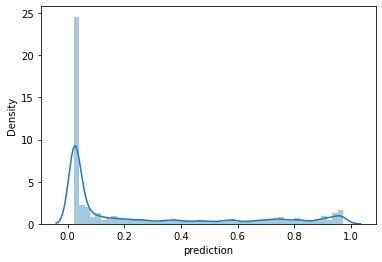

In [20]:
def plot_submission(df):
    sns.distplot(df['prediction'])
    print(df['prediction'].describe())
    print(len(df[df['prediction']>0.95]))
    plt.show()   

plot_submission(submission)

In [21]:
# submission['prediction'] *= .99
# submission.to_csv('submission.csv',index=False)